In [1]:
import sys
import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib import patches

sys.path.append('../src')
from fetch_savant import StatcastDataHandler


In [2]:

# load handler
handler = StatcastDataHandler()

#handler.update_local_sc(just_current=True)
# convenieseason_datance function for fetching seasons, game types
sc = handler.fetch_statcast(start_year=2024,game_types=['R'])

sc = pl.from_pandas(sc)


Fetching: [2024]


In [3]:
sc = (
    sc
    .with_columns((60.5 - pl.col('release_extension')).alias('yR'))
    .with_columns(( (-pl.col('vy0') - (pl.col('vy0')**2 - 2 * pl.col('ay') * (50 - pl.col('yR')) ).sqrt() ) / pl.col('ay')).alias('tR'))
    .with_columns(
        (pl.col('vx0') + pl.col('ax') * pl.col('tR')).alias('vxR'),
        (pl.col('vy0') + pl.col('ay') * pl.col('tR')).alias('vyR'),
        (pl.col('vz0') + pl.col('az') * pl.col('tR')).alias('vzR')
    )
    .with_columns(
        pl.arctan2('vyR','vxR').alias('HRA'),
        pl.arctan2('vyR','vzR').alias('VRA')
    )
    .with_columns(
        (pl.col('HRA').degrees() + 90).alias('HRA_deg'),
        (pl.col('VRA').degrees() + 90).alias('VRA_deg')
    )
    .drop_nulls(subset=['pitch_type', 'vxR', 'vyR', 'vzR'])
)

In [4]:
sc_filter = (
    sc
    .filter(pl.len().over(['pitcher','pitch_type']) >= 150)
    .with_columns(
        (pl.col('HRA_deg') - pl.col('HRA_deg').mean().over(['pitcher','pitch_type']) ).alias('HRA_deg_rel'),
        (pl.col('VRA_deg') - pl.col('VRA_deg').mean().over(['pitcher','pitch_type']) ).alias('VRA_deg_rel'),
    )
    
)

<Axes: xlabel='VRA_deg_rel', ylabel='Density'>

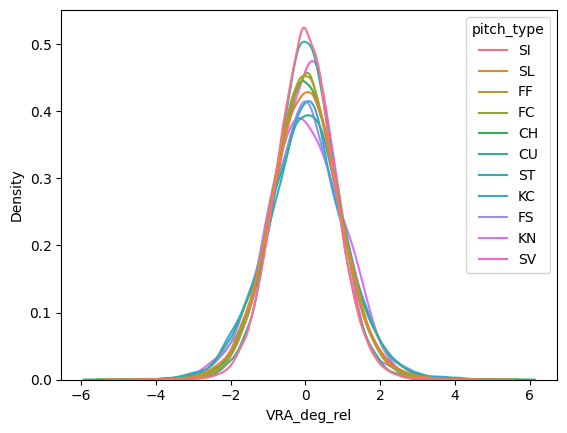

In [5]:

sns.kdeplot(data=sc_filter.to_pandas(), x='VRA_deg_rel', hue='pitch_type', fill=False, common_norm=False)

In [11]:
pitch_type = "FF"

vals = sc_filter.filter(pl.col('pitch_type') == pitch_type)['HRA_deg_rel'].drop_nans().to_numpy()

inner_range = 50
lb,ub = np.percentile(vals, (50 - (inner_range/2),50 + (inner_range/2)) )

arc_len = np.max((ub,lb)) - np.min((ub,lb))


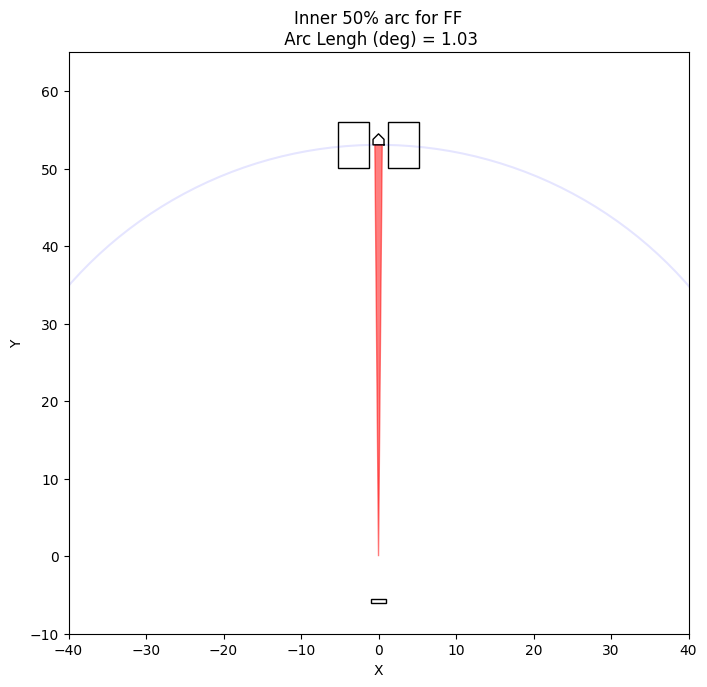

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming lb and ub are already defined
lb_rad = np.deg2rad((lb - 270) % 360)
ub_rad = np.deg2rad((ub - 270) % 360)

# Create a figure and axis
fig, ax = plt.subplots(figsize = (8,8),subplot_kw={'aspect': 'equal'})

extension = 6
origin = 60.5
hp_side_len = 17/12

scale  = (origin - extension) - hp_side_len

# Plot the unit half circle
theta = np.linspace(0, np.pi, 100)
x = np.cos(theta) * scale
y = np.sin(theta) * scale
ax.plot(x, y, 'b',alpha = .1)

# Plot the slice
slice_theta = np.linspace(lb_rad, ub_rad, 100)
slice_x = np.cos(slice_theta) * scale
slice_y = np.sin(slice_theta) * scale

# Include the center point (0, 0) to create a pie slice
ax.fill(np.concatenate(([0], slice_x)), np.concatenate(([0], slice_y)), color='red', alpha=0.5)

# add home plate
shift = np.array([0,scale])
home_plate_coords = np.array([
    [(17/24),0],
    [(17/24),8.5/12],
    [0,17/12],
    [-(17/24),8.5/12],
    [-(17/24),0],
    [(17/24),0]
]) + shift


home_plate_poly = Polygon(home_plate_coords)

x, y = home_plate_poly.exterior.xy
ax.plot(x, y, c="black",linewidth = 1)

# add pitcher's mound
ax.add_patch(patches.Rectangle((-1,-extension ),2, .5, edgecolor='black',
   facecolor='none', linewidth=1))

# add batter's box
ax.add_patch(patches.Rectangle( ( -(((17/24) + .5 + 4)),(origin - extension) - hp_side_len - 3 ) ,4, 6, edgecolor='black',
   facecolor='none', linewidth=1))
# add batter's box

ax.add_patch(patches.Rectangle( ((17/24) + .5,(origin - extension) - hp_side_len - 3 ) ,4, 6, edgecolor='black',
   facecolor='none', linewidth=1))

# Set the limits and labels
ax.set_xlim(-40, 40)
ax.set_ylim(-10, 65)

ax.set_xlabel('X')
ax.set_ylabel('Y')

title = f'Inner {inner_range}% arc for {pitch_type}\n Arc Lengh (deg) = {arc_len:.2f}'
ax.set_title(title)

# Show the plot
plt.show()

In [37]:
lb = np.rad2deg(np.arctan2(60.5 - extension,.5 + (17/24)))
ub = np.rad2deg(np.arctan2(60.5 - extension,(17/24)))

arc_len = np.max((ub,lb)) - np.min((ub,lb))


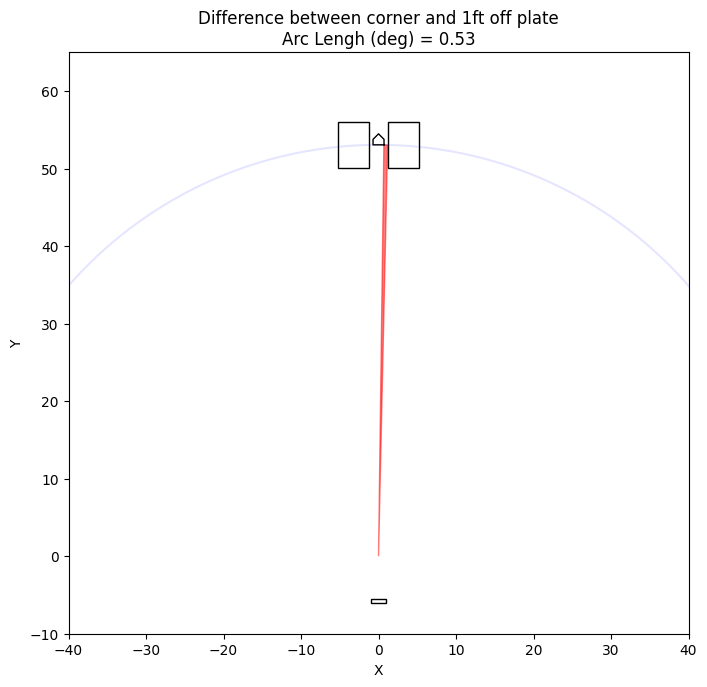

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming lb and ub are already defined
lb_rad = np.deg2rad(lb) #np.deg2rad((lb - 270) % 360)
ub_rad = np.deg2rad(ub) #np.deg2rad((ub - 270) % 360)

# Create a figure and axis
fig, ax = plt.subplots(figsize = (8,8),subplot_kw={'aspect': 'equal'})

extension = 6
origin = 60.5
hp_side_len = 17/12

scale  = (origin - extension) - hp_side_len

# Plot the unit half circle
theta = np.linspace(0, np.pi, 100)
x = np.cos(theta) * scale
y = np.sin(theta) * scale
ax.plot(x, y, 'b',alpha = .1)

# Plot the slice
slice_theta = np.linspace(lb_rad, ub_rad, 100)
slice_x = np.cos(slice_theta) * scale
slice_y = np.sin(slice_theta) * scale

# Include the center point (0, 0) to create a pie slice
ax.fill(np.concatenate(([0], slice_x)), np.concatenate(([0], slice_y)), color='red', alpha=0.5)

# add home plate
shift = np.array([0,scale])
home_plate_coords = np.array([
    [(17/24),0],
    [(17/24),8.5/12],
    [0,17/12],
    [-(17/24),8.5/12],
    [-(17/24),0],
    [(17/24),0]
]) + shift


home_plate_poly = Polygon(home_plate_coords)

x, y = home_plate_poly.exterior.xy
ax.plot(x, y, c="black",linewidth = 1)

# add pitcher's mound
ax.add_patch(patches.Rectangle((-1,-extension ),2, .5, edgecolor='black',
   facecolor='none', linewidth=1))

# add batter's box
ax.add_patch(patches.Rectangle( ( -(((17/24) + .5 + 4)),(origin - extension) - hp_side_len - 3 ) ,4, 6, edgecolor='black',
   facecolor='none', linewidth=1))
# add batter's box

ax.add_patch(patches.Rectangle( ((17/24) + .5,(origin - extension) - hp_side_len - 3 ) ,4, 6, edgecolor='black',
   facecolor='none', linewidth=1))

# Set the limits and labels
ax.set_xlim(-40, 40)
ax.set_ylim(-10, 65)

ax.set_xlabel('X')
ax.set_ylabel('Y')

title = f'Difference between corner and 1ft off plate\nArc Lengh (deg) = {arc_len:.2f}'
ax.set_title(title)

# Show the plot
plt.show()